<a id='step1'></a>
## Data Loader for Test Dataset

In [1]:
!pip install nltk
import nltk
nltk.download('punkt')

import torch
import torch.nn as nn
from torchvision import transforms
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from model import EncoderCNN, DecoderRNN
import math
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize
%load_ext autoreload
%autoreload 2

transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Vocabulary successfully loaded from vocab.pkl file!


Run the code cell below to visualize an example test image, before pre-processing is applied.

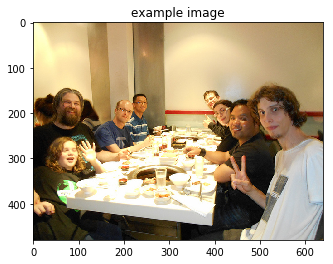

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

<a id='step2'></a>
## Load Trained Models

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Watch for any changes in model.py, and re-load it automatically.
% load_ext autoreload
% autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

encoder_file = 'encoder_5-5.pkl'
decoder_file = 'decoder_5-5.pkl'
embed_size = 512
hidden_size = 512
vocab_size = len(data_loader.dataset.vocab)
print (vocab_size)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
8855


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 94380670.14it/s]


DecoderRNN(
  (word_embeddings): Embedding(8855, 512)
  (lstm): LSTM(512, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=8855, bias=True)
)

In [5]:
image = image.to(device)
features = encoder(image).unsqueeze(1)
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output: [0, 3, 80, 13, 51, 224, 192, 3, 112, 21, 109, 18, 1, 1, 18, 1, 1, 18, 1, 1]


In [6]:
def clean_sentence(output):
    sentense = ''
    for i in output:
        word = data_loader.dataset.vocab.idx2word[i]
        if i == 0: continue
        if i == 1: break
        if i == 18: sentense = sentense + word #restricting maxlen to 20
        else: sentense = sentense + ' ' + word
    return sentense.strip()

In [7]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: a group of people sitting around a table with food.


<a id='step5'></a>
## Generate Predictions

In [8]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

Run the code cell below (multiple times, if you like!) to test how this function works.

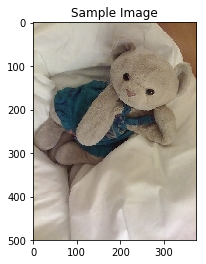

a small dog is laying on a bed with a stuffed animal.


In [9]:
get_prediction()

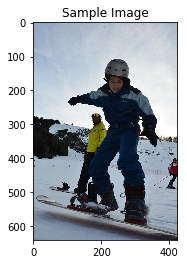

a man riding a snowboard down a snow covered slope.


In [12]:
get_prediction()

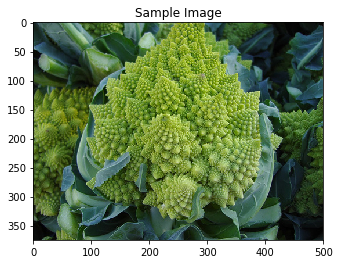

a bunch of broccoli growing in a field


In [21]:
get_prediction()

### The model could have performed better ...

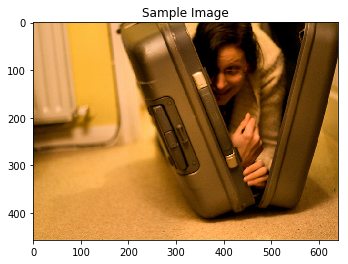

a woman is sitting in a chair talking on a phone


In [22]:
get_prediction()

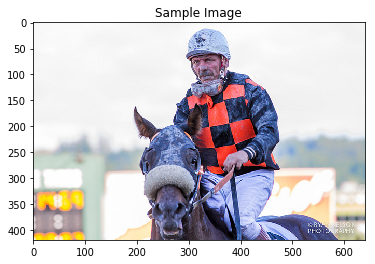

a man is sitting on a couch with a cat


In [63]:
get_prediction()